In [184]:
import numba
import numpy as np
from numba import jit
import warnings
import inspect

# To suppress all Numba warnings
warnings.filterwarnings('ignore', category=numba.NumbaWarning)


# Uml Diagram
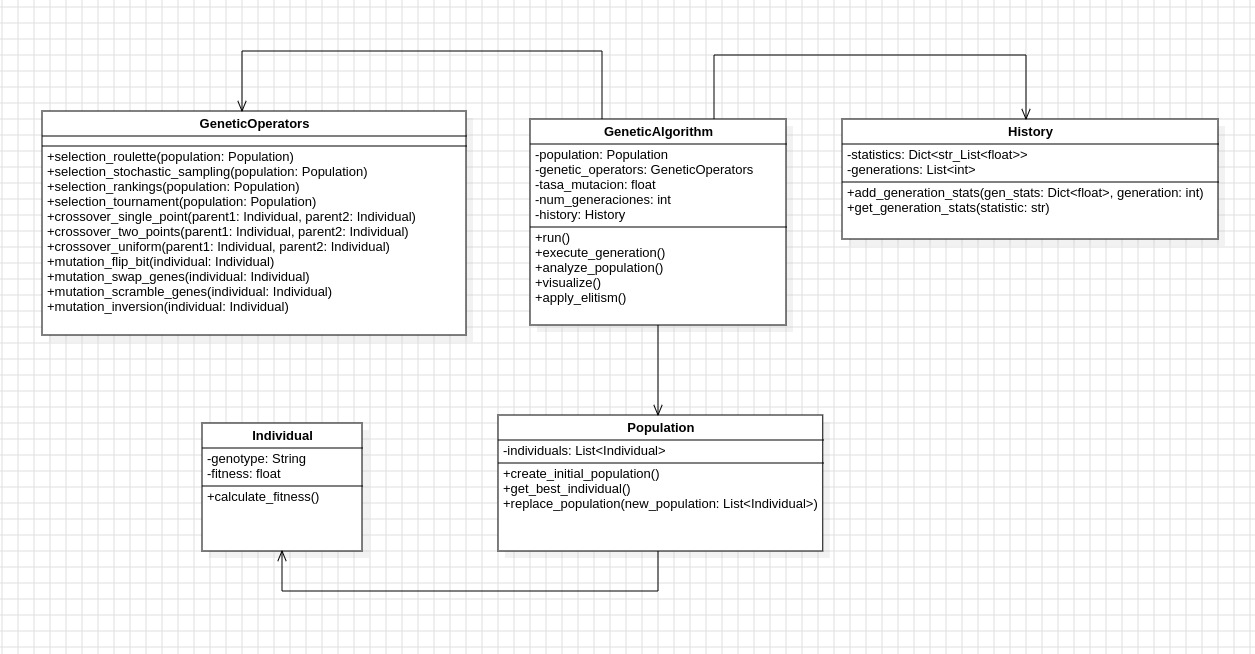

# Individual

# Genetic Operators

Selection methods (roulette, stochastic sampling, rankings, tournament)

Crossover methods (single-point, two-points, uniform)

Mutation methods (flip bit, swap genes, scramble genes, inversion)

# Population

# Tests

Funcionan todos los componentes, solo falta la integracion y estadisticos

In [5]:
from numba import jit, njit
import numpy as np
import inspect
import matplotlib.pyplot as plt
plt.style.use('ggplot')

class GeneticOperations:
    @staticmethod
    def selection_tournament(population, num_parents):
        selected_parents = np.empty(num_parents, dtype=object)
        population_size = len(population.individuals)
        for i in range(num_parents):
            tournament_size = min(5, population_size)
            individuals = population.individuals[:]
            tournament = np.random.choice(individuals, tournament_size, replace=False)
            winner = max(tournament, key=lambda ind: ind.fitness)
            selected_parents[i] = winner

        return selected_parents
    
    @staticmethod
    def selection_roulette(population, num_parents):
        selected_parents = np.empty(num_parents, dtype=object)
        population_size = len(population.individuals)
        fitness_values = np.array([ind.fitness for ind in population.individuals])
        total_fitness = np.sum(fitness_values)

        for i in range(num_parents):
            rand_value = np.random.rand() * total_fitness
            partial_sum = 0
            for j in range(population_size):
                partial_sum += fitness_values[j]
                if partial_sum >= rand_value:
                    selected_parents[i] = population.individuals[j]
                    break

        return selected_parents

    @staticmethod
    def selection_stochastic_sampling(population, num_parents):
        selected_parents = np.empty(num_parents, dtype=object)
        population_size = len(population.individuals)
        fitness_values = np.array([ind.fitness for ind in population.individuals])
        fitness_probabilities = fitness_values / np.sum(fitness_values)

        for i in range(num_parents):
            selected_index = np.random.choice(population_size, p=fitness_probabilities)
            selected_parents[i] = population.individuals[selected_index]

        return selected_parents

    @staticmethod
    def selection_rankings(population, num_parents):
        selected_parents = np.empty(num_parents, dtype=object)
        population_size = len(population.individuals)
        fitness_values = np.array([ind.fitness for ind in population.individuals])
        sorted_indices = np.argsort(fitness_values)

        for i in range(num_parents):
            rank_probabilities = np.arange(1, population_size + 1) / np.sum(np.arange(1, population_size + 1))
            selected_index = np.random.choice(sorted_indices, p=rank_probabilities)
            selected_parents[i] = population.individuals[selected_index]

        return selected_parents

    @staticmethod
    def crossover_single_point(parents, num_offspring):
        offspring = np.empty(num_offspring, dtype=object)
        num_parents = len(parents)
        if num_parents < 2:
            raise ValueError("Se necesitan al menos dos padres para realizar el cruce.")

        for i in range(num_offspring):
            parent1, parent2 = np.random.choice(parents, 2, replace=False)
            crossover_point = np.random.randint(1, len(parent1.chromosome) - 1)
            child_chromosome = np.concatenate((parent1.chromosome[:crossover_point], parent2.chromosome[crossover_point:]))
            child = Individual(child_chromosome)
            offspring[i] = child

        return offspring
    
    @staticmethod
    def crossover_two_points(parents, num_offspring):
        offspring = np.empty(num_offspring, dtype=object)
        num_parents = len(parents)
        if num_parents < 2:
            raise ValueError("Se necesitan al menos dos padres para realizar el cruce.")

        for i in range(num_offspring):
            parent1, parent2 = np.random.choice(parents, 2, replace=False)
            crossover_points = np.sort(np.random.choice(len(parent1.chromosome) - 1, 2, replace=False))
            child_chromosome = np.concatenate((parent1.chromosome[:crossover_points[0]], parent2.chromosome[crossover_points[0]:crossover_points[1]], parent1.chromosome[crossover_points[1]:]))
            child = Individual(child_chromosome)
            offspring[i] = child

        return offspring
    
    @staticmethod
    def crossover_uniform(parents, num_offspring):
        offspring = np.empty(num_offspring, dtype=object)
        num_parents = len(parents)
        if num_parents < 2:
            raise ValueError("Se necesitan al menos dos padres para realizar el cruce.")

        for i in range(num_offspring):
            parent1, parent2 = np.random.choice(parents, 2, replace=False)
            mask = np.random.randint(0, 2, size=len(parent1.chromosome), dtype=np.int8)
            child_chromosome = np.where(mask, parent1.chromosome, parent2.chromosome)
            child = Individual(child_chromosome)
            offspring[i] = child

        return offspring

    @staticmethod
    def mutation_flit_bit(offspring : np.ndarray, mutation_rate : float):
        for child in offspring:
            mutation_mask = np.random.rand(len(child.chromosome)) < mutation_rate
            child.chromosome = np.logical_xor(child.chromosome, mutation_mask).astype(np.int8)
        return offspring

    @staticmethod
    def mutation_swap_genes(offspring: np.ndarray, mutation_rate: float):
        for child in offspring:
            if np.random.rand() < mutation_rate:
                gene_indices = np.random.choice(len(child.chromosome), 2, replace=False)
                child.chromosome[gene_indices] = child.chromosome[gene_indices[::-1]]
        return offspring

    @staticmethod
    def mutation_scramble_genes(offspring: np.ndarray, mutation_rate: float):
        for child in offspring:
            if np.random.rand() < mutation_rate:
                gene_indices = np.random.choice(len(child.chromosome), 2, replace=False)
                gene_indices.sort()
                scrambled_genes = child.chromosome[gene_indices[0]:gene_indices[1]]
                np.random.shuffle(scrambled_genes)
                child.chromosome[gene_indices[0]:gene_indices[1]] = scrambled_genes
        return offspring

    @staticmethod
    def mutation_inversion(offspring: np.ndarray, mutation_rate: float):
        for child in offspring:
            if np.random.rand() < mutation_rate:
                gene_indices = np.random.choice(len(child.chromosome), 2, replace=False)
                gene_indices.sort()
                segment_to_invert = child.chromosome[gene_indices[0]:gene_indices[1]]
                child.chromosome[gene_indices[0]:gene_indices[1]] = segment_to_invert[::-1]
        return offspring
    
    @staticmethod
    def elitism(population, num_individuals):
        sorted_population = sorted(population.individuals, key=lambda ind: ind.fitness, reverse=True)
        elite_individuals = np.array(sorted_population[:num_individuals], dtype=object)
        return elite_individuals

class Individual:
    def __init__(self, chromosome : np.ndarray):
        self.chromosome = np.array(chromosome, dtype=np.int8)
        self.fitness = 0

    @jit(nopython=True)
    def calculate_fitness(chromosome):
        return np.sum(chromosome)

class Population:
    def __init__(self, size, chromosome_length, chromosome_prob):
        self.size = size
        self.chromosome_length = chromosome_length
        self.chromosome_prob = chromosome_prob
        self.individuals = np.empty(size, dtype=object)
        self.population_fitness = 0
        self.population_mean_fitness = 0
        self.eval_fun_numba = Individual.calculate_fitness
        self.mean_population_fitness = 0

    def initialize_population(self):
        for i in range(self.size):
            chromosome = np.random.choice([0, 1], size=self.chromosome_length, p=[1 - self.chromosome_prob, self.chromosome_prob])
            self.individuals[i] = Individual(chromosome)

    def evaluate_individuals_population(self):
        for individual in self.individuals:
            self.population_fitness += individual.fitness

    def evaluate_population(self):
        total_fitness_population = 0
        for individual in self.individuals:
            individual.fitness = self.eval_fun_numba(individual.chromosome)
            total_fitness_population += individual.fitness
        self.mean_population_fitness = total_fitness_population / self.individuals.shape[0]

    def get_best_individual(self):
        best_individual = max(self.individuals, key=lambda ind: ind.fitness)
        return best_individual

    def get_worst_individual(self):
        worst_individual = min(self.individuals, key=lambda ind: ind.fitness)
        return worst_individual

class History:
    def __init__(self, historical_dict):
        self.historical_dict =historical_dict

    def plot(self):
        plt.plot(self.historical_dict['individual_fitness'])

class GeneticAlgorithm:
    def __init__(self, population_size, chromosome_length, chromosome_prob, num_generations, crossover_parents, mutation_rate, percent_elitism_pop, elitism):
        self.population = Population(population_size, chromosome_length, chromosome_prob)
        self.num_generations = num_generations
        self.crossover_parents = crossover_parents
        self.mutation_rate = mutation_rate
        self.elite_individuals = np.int8(self.population.individuals.shape[0] * percent_elitism_pop)
        self.elitism = elitism
        self.historical_best_individual = []
        self.historical_worst_individual = []
        self.historical_mean_population_fitness = []

    def run(self):
        self.population.initialize_population()
        for generation in range(self.num_generations):
            self.population.evaluate_individuals_population()
            self.population.evaluate_population()
            best_individual = self.population.get_best_individual()
            worst_individual = self.population.get_worst_individual()
            print(f"Generación {generation}: Mejor aptitud = {best_individual.fitness}, Peor aptitud = {worst_individual.fitness}")
            self.historical_best_individual.append(best_individual)
            self.historical_worst_individual.append(worst_individual)
            self.historical_mean_population_fitness.append(self.population.mean_population_fitness)


            parents = GeneticOperations.selection_tournament(self.population, self.crossover_parents)
            num_offspring = self.population.size - self.crossover_parents - self.elite_individuals if self.elitism else self.population.size - self.crossover_parents
            offspring = GeneticOperations.crossover_uniform(parents, num_offspring)
            offspring = GeneticOperations.mutation_scramble_genes(offspring, self.mutation_rate)
            
            if self.elitism:
                elite_individuals = GeneticOperations.elitism(self.population, self.elite_individuals)
                self.population.individuals = np.concatenate((parents, offspring, elite_individuals))
            else:
                self.population.individuals = np.concatenate((parents, offspring))
    
    def visualize(self):
        fitness_best_values = [individual.fitness for individual in self.historical_best_individual]
        fitness_worst_values = [individual.fitness for individual in self.historical_worst_individual]
        plt.figure(figsize=(14, 8))
        plt.plot(fitness_best_values, label='Mejor individuo de la población')
        plt.plot(fitness_worst_values, label='Peor individuo de la población')
        plt.plot(self.historical_mean_population_fitness, label='Media de la población')
        plt.xlabel('Numero de generaciones')
        plt.ylabel('Fitness')
        plt.legend()


* mutation_flit_bit: 0.001 -> llega lento al valor de fitness pero tiene una ganancia constante, llega al mejor individuo
* mutation_inversion: 0.1 -> llega rapido a un valor de fitness alto, cambios bruscos en el fitness
* mutation_scramble_genes: 0.05 -> llega rapido a un valor de fitness alto, cambios bruscos, hay que manipular mucho para encontrar el mejor individuo
* mutation_swap_genes: 0.8, 0.9 -> llega muy lento a valores de fitness altos, requiere un indice de mutacion muy elevado, llega al mejor individuo

Generación 0: Mejor aptitud = 1050, Peor aptitud = 957
Generación 1: Mejor aptitud = 1050, Peor aptitud = 1050
Generación 2: Mejor aptitud = 1050, Peor aptitud = 1050
Generación 3: Mejor aptitud = 1050, Peor aptitud = 1050
Generación 4: Mejor aptitud = 1050, Peor aptitud = 1050
Generación 5: Mejor aptitud = 1050, Peor aptitud = 1050
Generación 6: Mejor aptitud = 1050, Peor aptitud = 1050
Generación 7: Mejor aptitud = 1050, Peor aptitud = 1050
Generación 8: Mejor aptitud = 1050, Peor aptitud = 1050
Generación 9: Mejor aptitud = 1050, Peor aptitud = 1050
Generación 10: Mejor aptitud = 1050, Peor aptitud = 1050
Generación 11: Mejor aptitud = 1050, Peor aptitud = 1050
Generación 12: Mejor aptitud = 1050, Peor aptitud = 1050
Generación 13: Mejor aptitud = 1050, Peor aptitud = 1050
Generación 14: Mejor aptitud = 1050, Peor aptitud = 1050
Generación 15: Mejor aptitud = 1050, Peor aptitud = 1050
Generación 16: Mejor aptitud = 1050, Peor aptitud = 1050
Generación 17: Mejor aptitud = 1050, Peor 

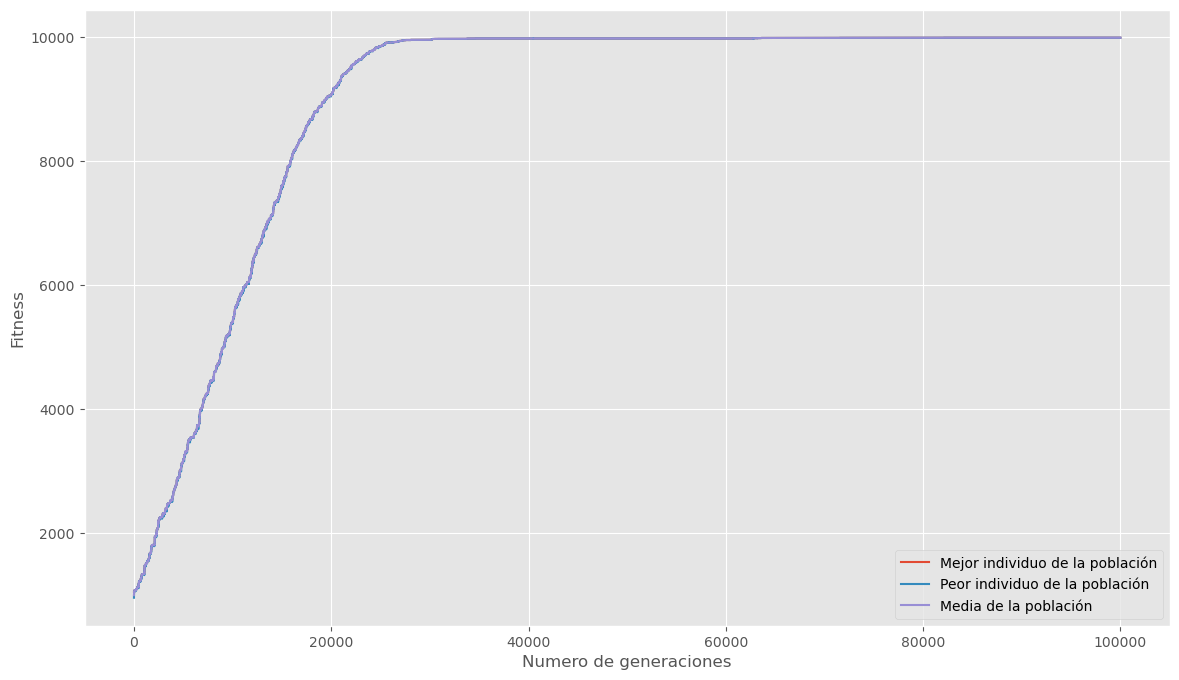

In [10]:
ga = GeneticAlgorithm(
    population_size=5, 
    chromosome_length=10000, 
    chromosome_prob=0.1, 
    num_generations=100000, 
    crossover_parents=2, 
    mutation_rate=0.05, 
    elitism=True, 
    percent_elitism_pop = 0.2)
ga.run()
ga.visualize()

In [6]:
from PIL import Image


firma = Image.open('firma.png')

numpy_img = np.array(firma)

numpy_img.shape

(371, 773, 4)

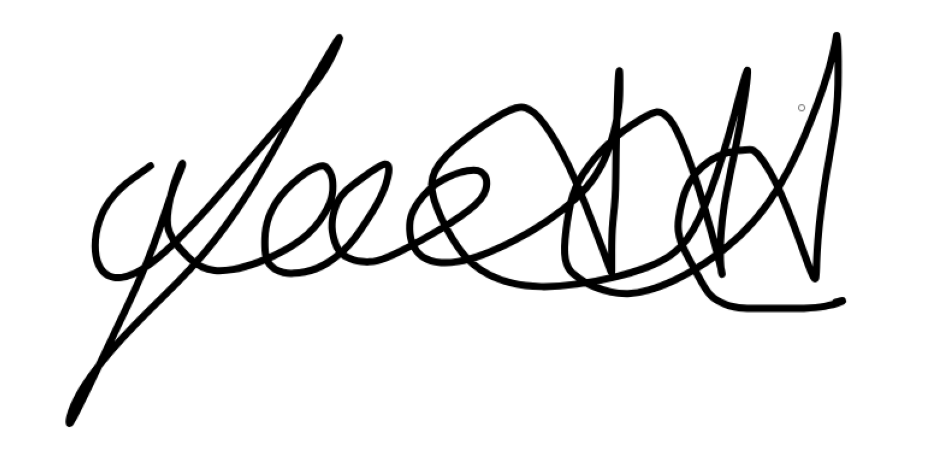

In [14]:
plt.figure(figsize=(12, 8))
plt.imshow(numpy_img, cmap='gray')
plt.axis("off")
plt.grid()

In [15]:
numpy_img.flatten().shape

(1147132,)